## Group 55 - Assignment 3 - Problem 2

<div class="alert alert-block alert-info">
<b>Note:</b>This notebook serves as our report. Suitable comments and explanations with visualizations were prodcued where and when needed.
</div>

<div class="alert alert-block alert-info">
    <b>Note:</b> <p>We have provided two files (Train_RNN.py and Test_RNN.py).</p
   > <p>The trained model is already saved in the models folder.</p> <p>In the Data folder, we have the two csv files for train and test (train_data_RNN.csv, test_data_RNN.csv) along with final.csv file (the new dataset with 12 features and 1 target value). </p> <p>We have two pickle files which have the Minmax object saved(used in the Test_RNN.py file for scaling the test data). </p>
</div>

***
### Recurrent Neural Networks for Regression
***

* Designing RNN for stock price prediction.
* Predict the next day open price using the past 3 days Open, High, and Low Prices, and Volume.

In [1]:
#Importing necessary libraries
import os
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import time 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from numpy import newaxis
import math
from sklearn.metrics import mean_squared_error

In [2]:
tf.random.set_seed(221)
np.random.seed(221)
os.environ['PYTHONHASHSEED']=str(221)

#### Dataset Creation

In [3]:
# Reading and storing the "q2_dataset.py" given
stocks_dataset =  pd.read_csv('q2_dataset.csv', header=0,parse_dates=['Date'])
stocks_dataset.columns = ['Date', 'close','volume','open','high','low']
stocks_dataset['close'] = stocks_dataset['close'].replace('[\$,]', '', regex=True).astype(float)
stocks_dataset=stocks_dataset.sort_values(by='Date',ascending=False)
stocks_dataset

,Date,close,volume,open,high,low
0,2020-07-08,381.37,29272970,376.72,381.50,376.36
1,2020-07-07,372.69,28106110,375.41,378.62,372.23
2,2020-07-06,373.85,29663910,370.00,375.78,369.87
3,2020-07-02,364.11,28510370,367.85,370.47,363.64
4,2020-07-01,364.11,27684310,365.12,367.36,363.91
...,...,...,...,...,...,...
1254,2015-07-15,126.82,33559770,125.72,127.15,125.58
1255,2015-07-14,125.61,31695870,126.04,126.37,125.04
1256,2015-07-13,125.66,41365600,125.03,125.76,124.32
1257,2015-07-10,123.28,61292800,121.94,123.85,121.21


* Creating a new data frame with past 3 days Open, High, and Low prices, and Volume
* Included next day’s opening price as Target

In [4]:
df = pd.DataFrame(columns=['open1', 'high1', 'low1', 'volume1',
                           'open2', 'high2', 'low2', 'volume2',
                           'open3', 'high3', 'low3', 'volume3','target'])

l= len(stocks_dataset.index)
i=0
while i < l-3:

    df.loc[i, 'open1'] = stocks_dataset["open"][i+3]
    df.loc[i, 'high1'] = stocks_dataset["high"][i+3]
    df.loc[i, 'low1'] = stocks_dataset["low"][i+3]
    df.loc[i, 'volume1'] = stocks_dataset["volume"][i+3]
    
    df.loc[i, 'open2'] = stocks_dataset["open"][i+2]
    df.loc[i, 'high2'] = stocks_dataset["high"][i+2]
    df.loc[i, 'low2'] = stocks_dataset["low"][i+2]
    df.loc[i, 'volume2'] = stocks_dataset["volume"][i+2]
    
    df.loc[i, 'open3'] = stocks_dataset["open"][i+1]
    df.loc[i, 'high3'] = stocks_dataset["high"][i+1]
    df.loc[i, 'low3'] = stocks_dataset["low"][i+1]
    df.loc[i, 'volume3'] = stocks_dataset["volume"][i+1]    
    
    df.loc[i, 'target'] = stocks_dataset["open"][i]      

    i =i+1
    
df.to_csv('final.csv', mode='w+', header=True, index=False)
final_dataset =  pd.read_csv('final.csv', header=0)
final_dataset

,open1,high1,low1,volume1,open2,high2,low2,volume2,open3,high3,low3,volume3,target
0,367.85,370.47,363.64,28510370,370.00,375.78,369.87,29663910,375.41,378.62,372.23,28106110,376.72
1,365.12,367.36,363.91,27684310,367.85,370.47,363.64,28510370,370.00,375.78,369.87,29663910,375.41
2,360.08,365.98,360.00,35055820,365.12,367.36,363.91,27684310,367.85,370.47,363.64,28510370,370.00
3,353.25,362.17,351.28,32661520,360.08,365.98,360.00,35055820,365.12,367.36,363.91,27684310,367.85
4,364.41,365.32,353.02,51314210,353.25,362.17,351.28,32661520,360.08,365.98,360.00,35055820,365.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,125.72,127.15,125.58,33559770,127.74,128.57,127.35,35987630,129.08,129.62,128.31,45970470,130.97
1252,126.04,126.37,125.04,31695870,125.72,127.15,125.58,33559770,127.74,128.57,127.35,35987630,129.08
1253,125.03,125.76,124.32,41365600,126.04,126.37,125.04,31695870,125.72,127.15,125.58,33559770,127.74
1254,121.94,123.85,121.21,61292800,125.03,125.76,124.32,41365600,126.04,126.37,125.04,31695870,125.72


* Splitting the data randomly into 70% for training and 30% for testing
* Saving the training and testing data as ‘train_data_RNN.csv’ and ‘test_data_RNN.csv’ respectively

In [5]:
train,test = train_test_split(final_dataset, test_size=0.30, random_state=42)
train.to_csv('train_data_RNN.csv', index=False, mode='w+')
test.to_csv('test_data_RNN.csv', index=False, mode='w+')
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Data Exploartion

* Exploring the types, dimensions/shape of the data
* Plotting the Target opening price in order to observe the trend of the data
* Plotting the Volume in order to observe if there are any irregularities in the data

In [6]:
train.shape, test.shape

((879, 13), (377, 13))

In [7]:
final_dataset.dtypes

open1      float64
high1      float64
low1       float64
volume1      int64
open2      float64
high2      float64
low2       float64
volume2      int64
open3      float64
high3      float64
low3       float64
volume3      int64
target     float64
dtype: object

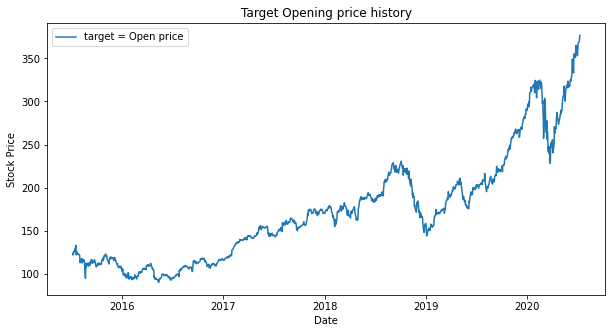

In [8]:
#Target pirce history plot
plt.figure(figsize=(10, 5))
plt.plot(stocks_dataset['Date'].values[::-1],stocks_dataset["open"].values[::-1])  #Reversing the plot as the given data has latest data samples in the start
plt.title('Target Opening price history')
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.legend(['target = Open price'], loc='upper left')
plt.show()

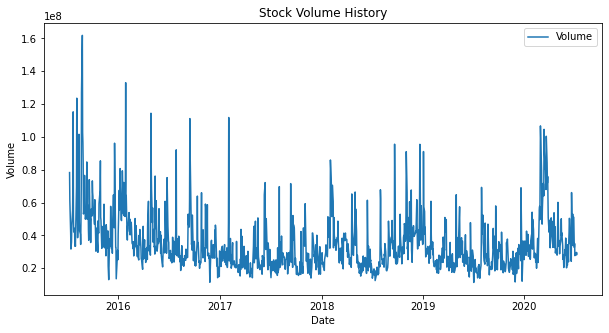

In [9]:
#Volume plot
plt.figure(figsize=(10, 5))
plt.plot(stocks_dataset['Date'].values[::-1],stocks_dataset["volume"].values[::-1]) #Reversing the plot as the given data has latest data samples in the start
plt.title('Stock Volume History')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.legend(['Volume'], loc='upper right')
plt.show()

#### Data preprocessing

* Checking if there are any Null data in the given dataset

In [10]:
final_dataset.isna().sum()

open1      0
high1      0
low1       0
volume1    0
open2      0
high2      0
low2       0
volume2    0
open3      0
high3      0
low3       0
volume3    0
target     0
dtype: int64

##### - Normalization of Training Data

In [11]:
#MinMaxScaler
train_dataset =  pd.read_csv('train_data_RNN.csv')
y_train=train_dataset[['target']]
x_train=train_dataset.drop(columns=['target'])

In [12]:
y_train.shape

(879, 1)

In [13]:
#MinMaxObject = MinMaxScaler(feature_range=(0,1))
MinMaxObject_x = MinMaxScaler(feature_range=(0,1))
MinMaxObject_y = MinMaxScaler(feature_range=(0,1))
norm_x_train = MinMaxObject_x.fit_transform(x_train)
norm_y_train = MinMaxObject_y.fit_transform(y_train)

In [14]:
# t_x_train=norm_x_train
# t_x_train=t_x_train.reshape(t_x_train.shape[0],t_x_train.shape[1] , 1)
# t_x_train.shape

In [15]:
# Splitting each normalized data sample into 3 arrays (Timestamps: t, t-1, and t-2)
# This will convert the data as 3 timestamps data with 4 features in each timestamp
dummy_x_train=[]
for i in range(len(norm_x_train)):
    z=np.split(norm_x_train[i], 3)
    dummy_x_train.append(np.array(z))
new_x_train=np.array(dummy_x_train)
new_x_train.shape

(879, 3, 4)

### Model Implementation - LSTM

There exists exploding gradient problem and vanishing gradient problem in a neyral network with a back propagation. In a Recurrent Neural Network these probelms become even worse as we are not just finding gradients with different layers but also through time. A special type of RNN, LSTM - Long Short Term Memory overcomes these issues with their cell states, also these have additional units(memory cells) which help in storing memory for longer periods. Hence LSTM has been considered for the implementation.

##### - LSTM Model 1 

LSTM Model 1 is designed with the following parameters: 
<br>Units/Neurons = 200, Layers = 2, Epochs = 100, Batch size = 32
<br>Optimizer = Adam, loss = mean_squared_error

In [16]:
model_lstm_1 = Sequential()
#adding 1st lstm layer
model_lstm_1.add(LSTM(units = 200, return_sequences = True, input_shape = (new_x_train.shape[1], 4)))
model_lstm_1.add(Dropout(rate = 0.2))

##adding 2nd lstm layer: 200 neurons
model_lstm_1.add(LSTM(units = 200, return_sequences = False))
model_lstm_1.add(Dropout(rate = 0.2))
'''
#adding 3rd lstm layer
model_lstm_1.add(LSTM(units = 200, return_sequences = False))
model_lstm_1.add(Dropout(rate = 0.2))
'''
##adding output layer
model_lstm_1.add(Dense(units = 1))

model_lstm_1.compile(optimizer='adam', loss='mean_squared_error')

model_lstm_1.fit(new_x_train, norm_y_train, epochs=100, batch_size=32)

Epoch 1/100
28/28 [==============================] - 19s 10ms/step - loss: 0.0411
Epoch 2/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 3/100
28/28 [==============================] - 0s 9ms/step - loss: 7.0067e-04
Epoch 4/100
28/28 [==============================] - 0s 10ms/step - loss: 6.4991e-04
Epoch 5/100
28/28 [==============================] - 0s 10ms/step - loss: 5.5922e-04
Epoch 6/100
28/28 [==============================] - 0s 10ms/step - loss: 5.0627e-04
Epoch 7/100
28/28 [==============================] - 0s 9ms/step - loss: 6.7905e-04
Epoch 8/100
28/28 [==============================] - 0s 15ms/step - loss: 6.6318e-04
Epoch 9/100
28/28 [==============================] - 0s 10ms/step - loss: 4.0949e-04
Epoch 10/100
28/28 [==============================] - 0s 9ms/step - loss: 7.0117e-04
Epoch 11/100
28/28 [==============================] - 0s 10ms/step - loss: 5.2783e-04
Epoch 12/100
28/28 [==============================] - 0s 10ms/step - loss:

28/28 [==============================] - 0s 10ms/step - loss: 3.3639e-04
Epoch 97/100
28/28 [==============================] - 0s 9ms/step - loss: 5.5364e-04
Epoch 98/100
28/28 [==============================] - 0s 9ms/step - loss: 3.7690e-04
Epoch 99/100
28/28 [==============================] - 0s 9ms/step - loss: 3.9419e-04
Epoch 100/100
28/28 [==============================] - 0s 10ms/step - loss: 4.0460e-04


In [18]:
train_predict_1 = model_lstm_1.predict(new_x_train) 
train_predict_1 = MinMaxObject_y.inverse_transform(train_predict_1)
loss_train = mean_squared_error(y_train,train_predict_1)
print("Loss on the training data of LSTM Model 1 (MSE) = " +str(loss_train))

Loss on the training data of LSTM Model 1 (MSE) = 13.865860269927666


##### - LSTM Model 2

LSTM Model 2 is designed with the following parameters: 
<br>Units/Neurons = 200, Layers = 2, Epochs = 500, Batch size = 64
<br>Optimizer = Adam, loss = mean_squared_error

In [19]:
model_lstm_2 = Sequential()
#adding 1st lstm layer
model_lstm_2.add(LSTM(units = 200, return_sequences = True, input_shape = (new_x_train.shape[1], 4)))
model_lstm_2.add(Dropout(rate = 0.2))

##adding 2nd lstm layer: 200 neurons
model_lstm_2.add(LSTM(units = 200, return_sequences = False))
model_lstm_2.add(Dropout(rate = 0.2))
'''
#adding 3rd lstm layer
model_lstm_2.add(LSTM(units = 200, return_sequences = False))
model_lstm_2.add(Dropout(rate = 0.2))
'''
##adding output layer
model_lstm_2.add(Dense(units = 1))

model_lstm_2.compile(optimizer='adam', loss='mean_squared_error')

model_lstm_2.fit(new_x_train, norm_y_train, epochs=500, batch_size=64)

Epoch 1/500
14/14 [==============================] - 32s 24ms/step - loss: 0.0698
Epoch 2/500
14/14 [==============================] - 0s 24ms/step - loss: 0.0047
Epoch 3/500
14/14 [==============================] - 0s 25ms/step - loss: 0.0018
Epoch 4/500
14/14 [==============================] - 0s 25ms/step - loss: 9.8223e-04
Epoch 5/500
14/14 [==============================] - 0s 24ms/step - loss: 8.5776e-04
Epoch 6/500
14/14 [==============================] - 0s 24ms/step - loss: 4.9810e-04
Epoch 7/500
14/14 [==============================] - 0s 29ms/step - loss: 7.3988e-04
Epoch 8/500
14/14 [==============================] - 0s 27ms/step - loss: 5.2276e-04
Epoch 9/500
14/14 [==============================] - 0s 25ms/step - loss: 5.9202e-04
Epoch 10/500
14/14 [==============================] - 0s 24ms/step - loss: 7.5644e-04
Epoch 11/500
14/14 [==============================] - 0s 27ms/step - loss: 5.7248e-04
Epoch 12/500
14/14 [==============================] - 0s 27ms/step - loss:

14/14 [==============================] - 0s 35ms/step - loss: 3.6186e-04
Epoch 97/500
14/14 [==============================] - 1s 38ms/step - loss: 5.4910e-04
Epoch 98/500
14/14 [==============================] - 0s 31ms/step - loss: 3.9366e-04
Epoch 99/500
14/14 [==============================] - 0s 27ms/step - loss: 3.9839e-04
Epoch 100/500
14/14 [==============================] - 0s 28ms/step - loss: 3.5238e-04
Epoch 101/500
14/14 [==============================] - 1s 37ms/step - loss: 4.9835e-04
Epoch 102/500
14/14 [==============================] - 0s 25ms/step - loss: 4.0863e-04
Epoch 103/500
14/14 [==============================] - 0s 26ms/step - loss: 3.9545e-04
Epoch 104/500
14/14 [==============================] - 0s 27ms/step - loss: 3.6478e-04
Epoch 105/500
14/14 [==============================] - 0s 25ms/step - loss: 3.1737e-04
Epoch 106/500
14/14 [==============================] - 0s 32ms/step - loss: 4.0354e-04
Epoch 107/500
14/14 [==============================] - 0s 24

14/14 [==============================] - 1s 41ms/step - loss: 3.4526e-04
Epoch 190/500
14/14 [==============================] - 1s 39ms/step - loss: 3.5736e-04: 0s - loss: 2.8
Epoch 191/500
14/14 [==============================] - 0s 26ms/step - loss: 3.3791e-04
Epoch 192/500
14/14 [==============================] - 0s 27ms/step - loss: 3.4581e-04
Epoch 193/500
14/14 [==============================] - 0s 28ms/step - loss: 4.8373e-04
Epoch 194/500
14/14 [==============================] - 0s 28ms/step - loss: 4.5766e-04
Epoch 195/500
14/14 [==============================] - 0s 27ms/step - loss: 3.5887e-04
Epoch 196/500
14/14 [==============================] - 0s 25ms/step - loss: 3.8259e-04
Epoch 197/500
14/14 [==============================] - 0s 26ms/step - loss: 3.7514e-04
Epoch 198/500
14/14 [==============================] - 0s 29ms/step - loss: 2.9173e-04: 0s - loss: 2.9015e-0
Epoch 199/500
14/14 [==============================] - 0s 28ms/step - loss: 3.0856e-04
Epoch 200/500
14/14

14/14 [==============================] - 0s 26ms/step - loss: 2.4776e-04
Epoch 283/500
14/14 [==============================] - 0s 26ms/step - loss: 3.3335e-04
Epoch 284/500
14/14 [==============================] - 0s 27ms/step - loss: 3.0564e-04
Epoch 285/500
14/14 [==============================] - 0s 26ms/step - loss: 3.2208e-04
Epoch 286/500
14/14 [==============================] - 0s 25ms/step - loss: 3.5140e-04
Epoch 287/500
14/14 [==============================] - 0s 25ms/step - loss: 2.9441e-04
Epoch 288/500
14/14 [==============================] - 0s 23ms/step - loss: 2.8505e-04
Epoch 289/500
14/14 [==============================] - 0s 25ms/step - loss: 2.9711e-04
Epoch 290/500
14/14 [==============================] - 0s 24ms/step - loss: 2.7508e-04
Epoch 291/500
14/14 [==============================] - 0s 24ms/step - loss: 2.8027e-04
Epoch 292/500
14/14 [==============================] - 0s 24ms/step - loss: 2.9971e-04
Epoch 293/500
14/14 [==============================] - 0s

14/14 [==============================] - 0s 26ms/step - loss: 3.1047e-04
Epoch 377/500
14/14 [==============================] - 0s 23ms/step - loss: 2.9743e-04
Epoch 378/500
14/14 [==============================] - 0s 25ms/step - loss: 2.5847e-04
Epoch 379/500
14/14 [==============================] - 0s 24ms/step - loss: 2.5373e-04
Epoch 380/500
14/14 [==============================] - 0s 23ms/step - loss: 2.9477e-04
Epoch 381/500
14/14 [==============================] - 0s 27ms/step - loss: 2.0664e-04
Epoch 382/500
14/14 [==============================] - 0s 27ms/step - loss: 2.5573e-04
Epoch 383/500
14/14 [==============================] - 0s 24ms/step - loss: 2.4710e-04
Epoch 384/500
14/14 [==============================] - 0s 25ms/step - loss: 2.4606e-04
Epoch 385/500
14/14 [==============================] - 0s 28ms/step - loss: 2.5793e-04
Epoch 386/500
14/14 [==============================] - 0s 27ms/step - loss: 2.6028e-04
Epoch 387/500
14/14 [==============================] - 0s

14/14 [==============================] - 0s 25ms/step - loss: 2.7212e-04
Epoch 470/500
14/14 [==============================] - 0s 24ms/step - loss: 2.8428e-04
Epoch 471/500
14/14 [==============================] - 0s 25ms/step - loss: 2.1565e-04
Epoch 472/500
14/14 [==============================] - 0s 25ms/step - loss: 2.4821e-04
Epoch 473/500
14/14 [==============================] - 0s 25ms/step - loss: 2.5278e-04
Epoch 474/500
14/14 [==============================] - 0s 25ms/step - loss: 2.5858e-04
Epoch 475/500
14/14 [==============================] - 0s 25ms/step - loss: 2.1689e-04
Epoch 476/500
14/14 [==============================] - 0s 23ms/step - loss: 2.1585e-04
Epoch 477/500
14/14 [==============================] - 0s 25ms/step - loss: 2.5787e-04
Epoch 478/500
14/14 [==============================] - 0s 25ms/step - loss: 2.4994e-04
Epoch 479/500
14/14 [==============================] - 0s 23ms/step - loss: 2.8323e-04
Epoch 480/500
14/14 [==============================] - 0s

In [20]:
# Prediction
train_predict_2 = model_lstm_2.predict(new_x_train) 
train_predict_2 = MinMaxObject_y.inverse_transform(train_predict_2)
#Loss Calculation on training data
loss_train = mean_squared_error(y_train,train_predict_2)
print("Loss on the training data of LSTM Model 2 (MSE) = " +str(loss_train))

Loss on the training data of LSTM Model 2 (MSE) = 10.151389068409598


##### - LSTM Model 3

LSTM Model 3 is designed with the following parameters: 
<br>Units/Neurons = 200, Layers = 2, Epochs = 1000, Batch size = 64
<br>Optimizer = Adam, loss = mean_squared_error

In [21]:
model_lstm_3 = Sequential()
#adding 1st lstm layer
#model_lstm_3.add(LSTM(units = 200, return_sequences = True, input_shape = (new_x_train.shape[1], 4)))
model_lstm_3.add(LSTM(units = 200, return_sequences = True, input_shape = (new_x_train.shape[1], 4)))
model_lstm_3.add(Dropout(rate = 0.2))

##adding 2nd lstm layer: 200 neurons
model_lstm_3.add(LSTM(units = 200, return_sequences = False))
model_lstm_3.add(Dropout(rate = 0.2))
'''
#adding 3rd lstm layer
model_lstm_3.add(LSTM(units = 200, return_sequences = False))
model_lstm_3.add(Dropout(rate = 0.2))
'''
##adding output layer
model_lstm_3.add(Dense(units = 1))
model_lstm_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 200)            164000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 200)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 485,001
Trainable params: 485,001
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_lstm_3.compile(optimizer='adam', loss='mean_squared_error')

model_lstm_3.fit(new_x_train, norm_y_train, epochs=1000, batch_size=64)

Epoch 1/1000
14/14 [==============================] - 23s 12ms/step - loss: 0.0707
Epoch 2/1000
14/14 [==============================] - 0s 12ms/step - loss: 0.0048
Epoch 3/1000
14/14 [==============================] - 0s 13ms/step - loss: 0.0017
Epoch 4/1000
14/14 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 5/1000
14/14 [==============================] - 0s 15ms/step - loss: 7.3731e-04
Epoch 6/1000
14/14 [==============================] - 0s 14ms/step - loss: 5.4324e-04
Epoch 7/1000
14/14 [==============================] - 0s 12ms/step - loss: 6.0945e-04
Epoch 8/1000
14/14 [==============================] - 0s 12ms/step - loss: 5.5656e-04
Epoch 9/1000
14/14 [==============================] - 0s 13ms/step - loss: 5.0142e-04
Epoch 10/1000
14/14 [==============================] - 0s 13ms/step - loss: 6.4243e-04
Epoch 11/1000
14/14 [==============================] - 0s 13ms/step - loss: 5.1433e-04
Epoch 12/1000
14/14 [==============================] - 0s 13ms/step

14/14 [==============================] - 0s 11ms/step - loss: 4.0832e-04
Epoch 96/1000
14/14 [==============================] - 0s 12ms/step - loss: 3.9665e-04
Epoch 97/1000
14/14 [==============================] - 0s 12ms/step - loss: 5.5309e-04
Epoch 98/1000
14/14 [==============================] - 0s 12ms/step - loss: 3.8930e-04
Epoch 99/1000
14/14 [==============================] - 0s 11ms/step - loss: 3.7558e-04
Epoch 100/1000
14/14 [==============================] - 0s 12ms/step - loss: 3.3499e-04
Epoch 101/1000
14/14 [==============================] - 0s 12ms/step - loss: 4.8623e-04
Epoch 102/1000
14/14 [==============================] - 0s 11ms/step - loss: 4.2770e-04
Epoch 103/1000
14/14 [==============================] - 0s 12ms/step - loss: 4.1879e-04
Epoch 104/1000
14/14 [==============================] - 0s 12ms/step - loss: 3.4507e-04
Epoch 105/1000
14/14 [==============================] - 0s 12ms/step - loss: 3.1433e-04
Epoch 106/1000
14/14 [=============================

14/14 [==============================] - 0s 12ms/step - loss: 2.9950e-04
Epoch 189/1000
14/14 [==============================] - 0s 12ms/step - loss: 3.5843e-04
Epoch 190/1000
14/14 [==============================] - 0s 12ms/step - loss: 3.5802e-04
Epoch 191/1000
14/14 [==============================] - 0s 11ms/step - loss: 3.7451e-04
Epoch 192/1000
14/14 [==============================] - 0s 12ms/step - loss: 3.6775e-04
Epoch 193/1000
14/14 [==============================] - 0s 13ms/step - loss: 4.5787e-04
Epoch 194/1000
14/14 [==============================] - 0s 11ms/step - loss: 4.8954e-04
Epoch 195/1000
14/14 [==============================] - 0s 11ms/step - loss: 3.9735e-04
Epoch 196/1000
14/14 [==============================] - 0s 12ms/step - loss: 4.2739e-04
Epoch 197/1000
14/14 [==============================] - 0s 12ms/step - loss: 3.8245e-04
Epoch 198/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.9019e-04
Epoch 199/1000
14/14 [=========================

14/14 [==============================] - 0s 12ms/step - loss: 3.1101e-04
Epoch 282/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.5665e-04
Epoch 283/1000
14/14 [==============================] - 0s 11ms/step - loss: 3.6126e-04
Epoch 284/1000
14/14 [==============================] - 0s 11ms/step - loss: 3.1945e-04
Epoch 285/1000
14/14 [==============================] - 0s 12ms/step - loss: 3.0312e-04
Epoch 286/1000
14/14 [==============================] - 0s 12ms/step - loss: 3.4493e-04
Epoch 287/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.6968e-04
Epoch 288/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.6909e-04
Epoch 289/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.9915e-04
Epoch 290/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.6817e-04
Epoch 291/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.8737e-04
Epoch 292/1000
14/14 [=========================

14/14 [==============================] - 0s 11ms/step - loss: 2.5579e-04
Epoch 375/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4137e-04
Epoch 376/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.9841e-04
Epoch 377/1000
14/14 [==============================] - 0s 11ms/step - loss: 3.0495e-04
Epoch 378/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.5779e-04
Epoch 379/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.5795e-04
Epoch 380/1000
14/14 [==============================] - 0s 11ms/step - loss: 3.0713e-04
Epoch 381/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.1490e-04
Epoch 382/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.6299e-04
Epoch 383/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4830e-04
Epoch 384/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.4249e-04
Epoch 385/1000
14/14 [=========================

14/14 [==============================] - 0s 10ms/step - loss: 2.5358e-04
Epoch 468/1000
14/14 [==============================] - 0s 11ms/step - loss: 3.1062e-04
Epoch 469/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.8392e-04
Epoch 470/1000
14/14 [==============================] - 0s 10ms/step - loss: 2.9924e-04
Epoch 471/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.2784e-04
Epoch 472/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4514e-04
Epoch 473/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.5552e-04
Epoch 474/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.5528e-04
Epoch 475/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.0818e-04
Epoch 476/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.2723e-04
Epoch 477/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.6149e-04
Epoch 478/1000
14/14 [=========================

14/14 [==============================] - 0s 12ms/step - loss: 2.3414e-04
Epoch 561/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.7836e-04
Epoch 562/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.3933e-04
Epoch 563/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.8358e-04
Epoch 564/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.4774e-04
Epoch 565/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.2048e-04
Epoch 566/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4275e-04
Epoch 567/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.1070e-04
Epoch 568/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.3727e-04
Epoch 569/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.3211e-04
Epoch 570/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4893e-04
Epoch 571/1000
14/14 [=========================

14/14 [==============================] - 0s 12ms/step - loss: 3.3115e-04
Epoch 654/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.4474e-04
Epoch 655/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.4903e-04
Epoch 656/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.7353e-04
Epoch 657/1000
14/14 [==============================] - 0s 11ms/step - loss: 3.0509e-04
Epoch 658/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.0845e-04
Epoch 659/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4525e-04
Epoch 660/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.3592e-04
Epoch 661/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.8150e-04
Epoch 662/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.2146e-04
Epoch 663/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.6388e-04
Epoch 664/1000
14/14 [=========================

14/14 [==============================] - 0s 11ms/step - loss: 3.0710e-04
Epoch 747/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.6731e-04
Epoch 748/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.5632e-04
Epoch 749/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.3100e-04
Epoch 750/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4113e-04
Epoch 751/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.5075e-04
Epoch 752/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.8446e-04
Epoch 753/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.5088e-04
Epoch 754/1000
14/14 [==============================] - 0s 11ms/step - loss: 4.0084e-04
Epoch 755/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.9044e-04
Epoch 756/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.2027e-04
Epoch 757/1000
14/14 [=========================

14/14 [==============================] - 0s 11ms/step - loss: 2.5235e-04
Epoch 840/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4819e-04
Epoch 841/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.5191e-04
Epoch 842/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.0277e-04
Epoch 843/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4414e-04
Epoch 844/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.6267e-04
Epoch 845/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.7491e-04
Epoch 846/1000
14/14 [==============================] - 0s 12ms/step - loss: 1.8799e-04
Epoch 847/1000
14/14 [==============================] - 0s 11ms/step - loss: 1.9942e-04
Epoch 848/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.2405e-04
Epoch 849/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.2883e-04
Epoch 850/1000
14/14 [=========================

14/14 [==============================] - 0s 12ms/step - loss: 2.5661e-04
Epoch 933/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4896e-04
Epoch 934/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.3569e-04
Epoch 935/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.0708e-04
Epoch 936/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.9327e-04
Epoch 937/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.3890e-04
Epoch 938/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.3759e-04
Epoch 939/1000
14/14 [==============================] - 0s 12ms/step - loss: 2.0205e-04
Epoch 940/1000
14/14 [==============================] - 0s 12ms/step - loss: 1.9476e-04
Epoch 941/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4555e-04
Epoch 942/1000
14/14 [==============================] - 0s 11ms/step - loss: 2.4452e-04
Epoch 943/1000
14/14 [=========================

In [23]:
train_predict = model_lstm_3.predict(new_x_train) 
train_predict = MinMaxObject_y.inverse_transform(train_predict)
loss_train = mean_squared_error(y_train,train_predict)
print("Loss on the training data of LSTM Model 3 (MSE)= " +str(loss_train))

Loss on the training data of LSTM Model 3 (MSE)= 8.615814735999862


Out of three implementations with different parameters, mean squared error loss was less for the third LSTM Model, hence finalized the hyperparameters as -  Units/Neurons = 200, Layers = 2, Epochs = 1000, and Batch size = 64

#### Saving the trained model

In [24]:
from tensorflow.keras.models import load_model

model_lstm_3.save('model\Group_55_RNN_model.hdf5')

##### - Normalization of Test Data

In [25]:
# Reading the "test_data_RNN.csv" which is created above
test_dataset =  pd.read_csv('test_data_RNN.csv')
y_test=test_dataset[['target']]
x_test=test_dataset.drop(columns=['target'])
y_test.shape

norm_x_test = MinMaxObject_x.transform(x_test) #MinMaxScaler
norm_y_test = MinMaxObject_y.transform(y_test)

test_x_test=norm_x_test
test_x_test=test_x_test.reshape(test_x_test.shape[0],test_x_test.shape[1] , 1)
test_x_test.shape

#Splitting the data into arrays - each sample has 3 timestamps of 4 features each
#This step is carried out so as to provide the input to the LSTM model appropriately
dummy_x_test=[]
for i in range(len(norm_x_test)):
    k=np.split(norm_x_test[i], 3)
    dummy_x_test.append(np.array(k))
    
new_x_test=np.array(dummy_x_test)
new_x_test.shape

(377, 3, 4)

### Evaluate the Model

In [26]:
value_predicted = model_lstm_3.predict(new_x_test) 

#### Loss calculation on Test data

In [27]:
test_predict = MinMaxObject_y.inverse_transform(value_predicted)
rmse_test = math.sqrt(mean_squared_error(y_test,test_predict))
loss_test = mean_squared_error(y_test,test_predict)
print("The performance metric considered is Mean squared Error")
#print("Root Mean squared error of LSTM Model 3 = " +str(rmse_test))
print("Loss on the testing data of LSTM Model 3 = " +str(loss_test))

The performance metric considered is Mean squared Error
Loss on the testing data of LSTM Model 3 = 8.767859272557532


#### Plot of True and Predicted Values

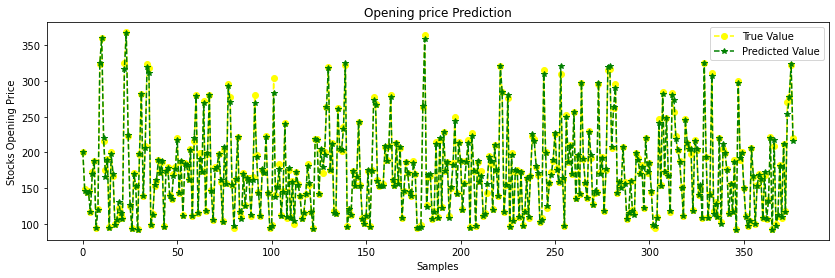

In [28]:
plt.figure(figsize=(14, 4))
plt.plot(y_test.values[::-1], linestyle='--',color='yellow',marker='o')
plt.plot(test_predict[::-1],linestyle='--', color= 'green',marker='*')
plt.legend(['True Value','Predicted Value'], loc='upper right')
plt.title("Opening price Prediction")
plt.xlabel("Samples")
plt.ylabel("Stocks Opening Price")
plt.show()

### Model Implementation - Gated Recurrent Unit(GRU)

In [29]:
model_GRU_1 = Sequential()
model_GRU_1.add(GRU(units=200, return_sequences=True, input_shape=(new_x_train.shape[1], 4)))
model_GRU_1.add(Dropout(rate = 0.2))
model_GRU_1.add(GRU(units=200))
model_GRU_1.add(Dropout(rate = 0.2))
model_GRU_1.add(Dense(units=1))
model_GRU_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3, 200)            123000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 200)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 200)               240600    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 363,801
Trainable params: 363,801
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_GRU_1.compile(optimizer='adam', loss='mean_squared_error')
model_GRU_1.fit(new_x_train, norm_y_train, epochs=100, batch_size=32)

Epoch 1/100
28/28 [==============================] - 5s 7ms/step - loss: 0.0199
Epoch 2/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 3/100
28/28 [==============================] - 0s 8ms/step - loss: 8.1471e-04
Epoch 4/100
28/28 [==============================] - 0s 8ms/step - loss: 6.9786e-04
Epoch 5/100
28/28 [==============================] - 0s 8ms/step - loss: 5.8311e-04
Epoch 6/100
28/28 [==============================] - 0s 8ms/step - loss: 5.4847e-04
Epoch 7/100
28/28 [==============================] - 0s 8ms/step - loss: 7.0119e-04
Epoch 8/100
28/28 [==============================] - 0s 8ms/step - loss: 8.1661e-04
Epoch 9/100
28/28 [==============================] - 0s 7ms/step - loss: 5.6988e-04
Epoch 10/100
28/28 [==============================] - 0s 7ms/step - loss: 8.0304e-04
Epoch 11/100
28/28 [==============================] - 0s 8ms/step - loss: 5.1722e-04
Epoch 12/100
28/28 [==============================] - 0s 8ms/step - loss: 6.3039e-

28/28 [==============================] - 0s 8ms/step - loss: 4.4238e-04
Epoch 98/100
28/28 [==============================] - 0s 8ms/step - loss: 3.6349e-04
Epoch 99/100
28/28 [==============================] - 0s 8ms/step - loss: 3.6653e-04
Epoch 100/100
28/28 [==============================] - 0s 9ms/step - loss: 3.4886e-04


In [31]:
train_predict_GRU_1 = model_GRU_1.predict(new_x_train) 
train_predict_GRU_1 = MinMaxObject_y.inverse_transform(train_predict_GRU_1)
loss_train_GRU_1 = mean_squared_error(y_train,train_predict_GRU_1)
print("Loss on the training data of GRU Model 1 = " +str(loss_train_GRU_1))

Loss on the training data of GRU Model 1 = 9.750507704292891


***
## Summary

**Dataset Creation:**
>The dataset given (q2_dataset.csv) has 4 features for each date. We are required to convert this dataset by using the latest 3 days as the features and the next day’s opening price as the target.<br>
<br>
>For doing the same, we have considered the 1st sample on the dataset as the Target sample(t) and the following 3 data samples as the Input data (t-1, t-2, and t-3).<br>
<br>
>We have created a dataframe with Open, High, Low and Volume columns for all the 3 days. Assigned the feature values of timestamps t-1, t-2, and t-3 to the 1st sample data point in the new dataframe.<br>
<br>
>We have assigned the (t) sample's Open price to the Target price column in the newly created Dataframe.<br>
<br>
>Repeated the process for all the data points and created a new dataset with 12 features in each sample and a target price column.<br>
<br>
>Final Dataset dimension = 1256 rows × 13 columns <br>
<br>
>This created dataset is randomly splitted into 70% for training and 30% for testing and saved as ‘train_data_RNN.csv’ and ‘test_data_RNN.csv’ respectively


**Preprocessing:**
>Train and Test data are normalized so as to scale the stock prices between (0,1). Normalization is performed as-
>- This helps in avoiding intensive calculations. 
>- The models learning happens quicker due to normalization of the data.
>- In order to have all the features (Open, High, Low prices, and Volume) of the data weighed equally and to avoid false prioritisation of data input to the network.

**Finding the Best Network:**
>- We have explored two Recurrent neural networks - Long Short-Term Memory (LSTM) and Gated recurrent units (GRU). We have done performance evaluation on both these RNN's and have finalized with LSTM due to better training and less loss incurred during our training.<br>
<br>
>- Usually for long sequences of data, LSTM model performs better when compared to GRU model.<br>
<br>
>- With GRU network, we have tuned the network(Units/Neurons, # of epochs, Batch size) and could produce the least loss when we have the following parameters: Number of epochs = 100, Batch size = 32 <br>
<br>
>- Training loss of LSTM = 8.6, Training loss of GRU = 9.7. As LSTM is giving us less loss when compared to GRU, so we have choosen <b>LSTM as our final model.</b> <br>
<br>
>- LSTMs have the ability to store past information which would be crucial for the future price prediction of stocks.<br>
<br>
>- In order to determine the best configuration for the LSTM, we have varied the parameters of the LSTM. Following are the parameters varied - number of layers, number of epochs, and batch size.<br>
<br>
>- In our implementations, we have carried out various combinations of the hyperparameters. In our code above,we have displayed 3 models with the variations in the parameters (Layers, Epochs and Batch size).<br>
<br>
>- As we increased the epochs and batch size, we have noticed the Loss(MSE) kept decreasing giving us a better trained network. But, when we increased the number of layers, we have observed that the loss increased. For this reason, we have limited to 2 layers in our network.<br>
<br>
>- Increasing the number of epochs above 1000, we have observed that the loss was increasing as the network was overfitting.<br>
<br>
>- Based on the above observations, we have choosen our network which was best fitting for the given data.

**Architecture of our Final Network:**
>- We have finalized the <b> model_lstm_3 (3rd LSTM model)</b> <br>
<br>
>- Following is the architecture of our LSTM network -
    1. LSTM Layer 1:      Units/Neurons = 200, Activation fucntion- "tanh", Recurrent Activation function- "Sigmoid"  
    2. Dropout Layer 1:   20% dropout 
    3. LSTM Layer 2:      Units/Neurons = 200, Activation fucntion- "tanh", Recurrent Activation function- "Sigmoid"
    4. Dropout Layer 2:   20% dropout 
    5. Output Layer:      Outputs the predicted stock price (o/p dimension = 1) <br>
<br>
>- Optimizer used is "Adam" so as to handle sparse gradients and to train the nework efficiently.<br>
>- Loss function choosen is "Mean Squared Error".
>- <b>Number of epochs = 1000, Batch size = 64 </b>(We have finalized these values after evaluating the loss and the performance of other combinations).

**Output of the Training loop:**
>The loss encountered during the training phase of the model is <b>8.6</b>

**Output from Testing:**
>The loss encountered during the testing phase of the model is <b>8.7</b> 
<br>
>The output plot of True vs Predicted values clearly depicts that majority of the predictions made by the finalized LSTM model are accurate. The predicted values lags behind the actual/true value when there are spikes in the prices. Apart from that, the model could replicate the upward and downward trends in the Opening price prediction.

**More days for features:**
>When we incorporate more days for features i.e.,stacking more timestamps data together, the output price predicted would be more accurate as the model would have reference to more data samples. This would allow the model to train well with the abnormal spikes in the prices which would decrease the loss factor further and improve the prediction of the opening price of the stock. 